In [2]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

import lib.models.content_based_2 as content_based
import lib.eval as eval

import importlib
importlib.reload(eval)
importlib.reload(content_based)


<module 'lib.models.content_based_2' from '/Users/mathiasraa/Desktop/ntnu/recommender-systems/src/lib/models/content_based_2.py'>

In [3]:
behavior_polars_train = pl.read_csv("../data/MINDlarge_train/behaviors.tsv", separator='\t', has_header=False)
behavior_polars_dev = pl.read_csv("../data/MINDlarge_dev/behaviors.tsv", separator='\t', has_header=False)
behavior_polars_train.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']
behavior_polars_dev.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']

In [ ]:
news_train = pl.read_csv("data/MINDlarge_train/news.tsv", separator='\t', has_header=False, quote_char=None)
news_dev = pl.read_csv("data/MINDlarge_dev/news.tsv", separator='\t', has_header=False, quote_char=None)
news_train.columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
news_dev.columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']

News data sample:


news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
str,str,str,str,str,str,str,str
"""N88753""","""lifestyle""","""lifestyleroyals""","""The Brands Queen Elizabeth, Pr…","""Shop the notebooks, jackets, a…","""https://assets.msn.com/labs/mi…","""[{""Label"": ""Prince Philip, Duk…","""[]"""
"""N45436""","""news""","""newsscienceandtechnology""","""Walmart Slashes Prices on Last…","""Apple's new iPad releases brin…","""https://assets.msn.com/labs/mi…","""[{""Label"": ""IPad"", ""Type"": ""J""…","""[{""Label"": ""IPad"", ""Type"": ""J""…"
"""N23144""","""health""","""weightloss""","""50 Worst Habits For Belly Fat""","""These seemingly harmless habit…","""https://assets.msn.com/labs/mi…","""[{""Label"": ""Adipose tissue"", ""…","""[{""Label"": ""Adipose tissue"", ""…"
"""N86255""","""health""","""medical""","""Dispose of unwanted prescripti…",null,"""https://assets.msn.com/labs/mi…","""[{""Label"": ""Drug Enforcement A…","""[]"""
"""N93187""","""news""","""newsworld""","""The Cost of Trump's Aid Freeze…","""Lt. Ivan Molchanets peeked ove…","""https://assets.msn.com/labs/mi…","""[]""","""[{""Label"": ""Ukraine"", ""Type"": …"



News data info:


statistic,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
str,str,str,str,str,str,str,str,str
"""count""","""101527""","""101527""","""101527""","""101527""","""96112""","""101527""","""101527""","""101527"""
"""null_count""","""0""","""0""","""0""","""0""","""5415""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null
"""min""","""N1""","""autos""","""ads-latingrammys""","""""1619 Project"" reporter detail…","""""#RedPaul"" began trending afte…","""https://assets.msn.com/labs/mi…","""[]""","""[]"""
"""25%""",null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null
"""max""","""N99999""","""weather""","""yearinoffbeatgoodnews""","""﻿﻿Princess Charlene of Monaco …","""﻿UPDATE @ 9:40 a.m.:""","""https://assets.msn.com/labs/mi…","""[{""Label"": ""\u014ckami"", ""Type…","""[{""Label"": ""\u0243"", ""Type"": ""…"


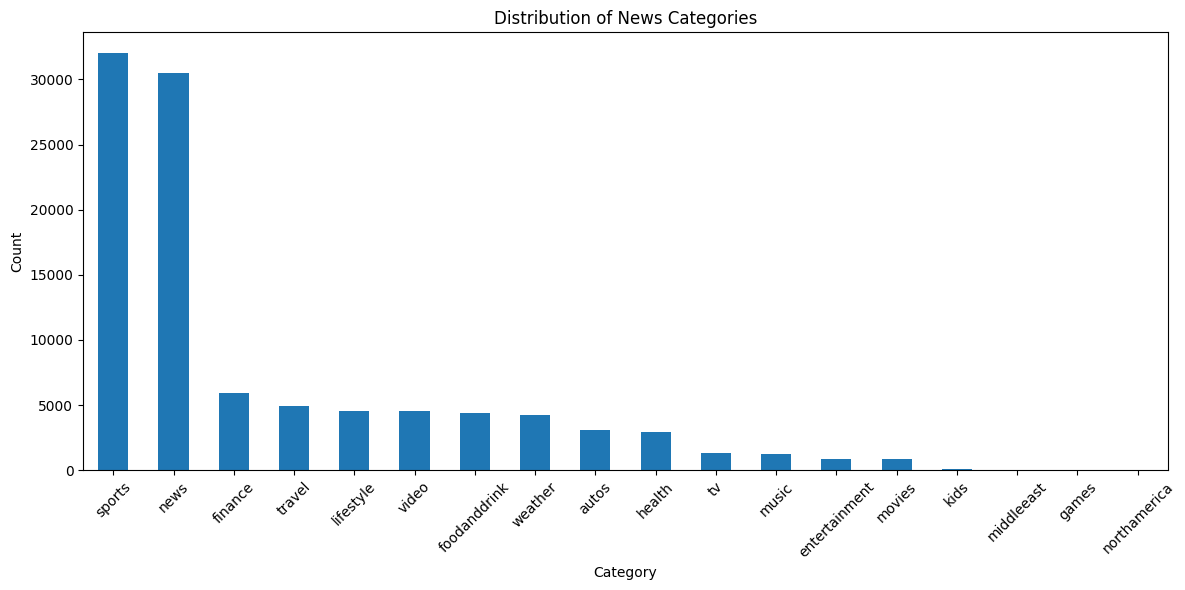


Missing values per column:


news_id                 0
category                0
subcategory             0
title                   0
abstract             5415
url                     0
title_entities          0
abstract_entities       0
dtype: int64

In [111]:
print("News data sample:")
display(news_train.head())
print("\nNews data info:")
display(news_train.describe())

# Category distribution
plt.figure(figsize=(12, 6))
news_train['category'].to_pandas().value_counts().plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for missing values
missing_values = news_train.to_pandas().isnull().sum()
print("\nMissing values per column:")
display(missing_values)


Behaviors data sample:


impression_id,user_id,timestamp,history,impressions
i64,str,str,str,str
1,"""U87243""","""11/10/2019 11:30:54 AM""","""N8668 N39081 N65259 N79529 N73…","""N78206-0 N26368-0 N7578-0 N585…"
2,"""U598644""","""11/12/2019 1:45:29 PM""","""N56056 N8726 N70353 N67998 N83…","""N47996-0 N82719-0 N117066-0 N8…"
3,"""U532401""","""11/13/2019 11:23:03 AM""","""N128643 N87446 N122948 N9375 N…","""N103852-0 N53474-0 N127836-0 N…"
4,"""U593596""","""11/12/2019 12:24:09 PM""","""N31043 N39592 N4104 N8223 N114…","""N38902-0 N76434-0 N71593-0 N10…"
5,"""U239687""","""11/14/2019 8:03:01 PM""","""N65250 N122359 N71723 N53796 N…","""N76209-0 N48841-0 N67937-0 N62…"



Behaviors data info:


statistic,impression_id,user_id,timestamp,history,impressions
str,f64,str,str,str,str
"""count""",2.232748e6,"""2232748""","""2232748""","""2186683""","""2232748"""
"""null_count""",0.0,"""0""","""0""","""46065""","""0"""
"""mean""",1116374.5,null,null,null,null
"""std""",644538.973754,null,null,null,null
"""min""",1.0,"""U0""","""11/10/2019 10:00:00 AM""","""N100 N59026 N114247""","""N10000-0 N7084-0 N88891-0 N164…"
"""25%""",558188.0,null,null,null,null
"""50%""",1.116375e6,null,null,null,null
"""75%""",1.674561e6,null,null,null,null
"""max""",2.232748e6,"""U99999""","""11/9/2019 9:59:59 PM""","""N99981 N72493 N127780 N30465 N…","""N99999-0 N47925-0 N88410-0 N48…"


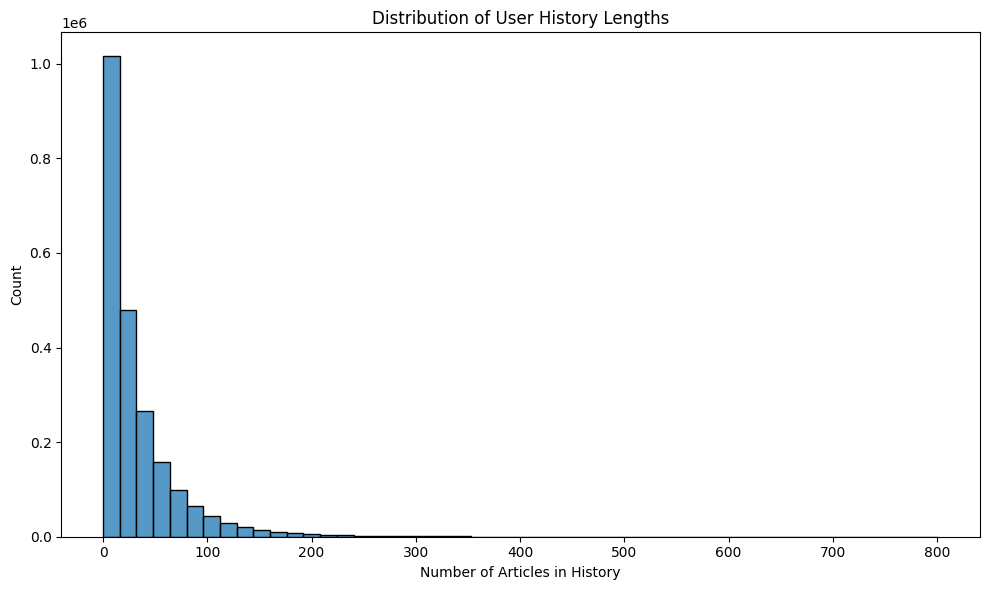


Users with no history: 46065
Average history length: 32.98 articles


In [112]:
print("Behaviors data sample:")
display(behavior_polars_train.head())
print("\nBehaviors data info:")
display(behavior_polars_train.describe())

duplicated_behaviors = behavior_polars_train.to_pandas().copy()


# Analyze history lengths
duplicated_behaviors['history_length'] = duplicated_behaviors['history'].fillna('').apply(lambda x: len(x.split()) if x else 0)

plt.figure(figsize=(10, 6))
sns.histplot(duplicated_behaviors['history_length'], bins=50)
plt.title('Distribution of User History Lengths')
plt.xlabel('Number of Articles in History')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"\nUsers with no history: {sum(duplicated_behaviors['history_length'] == 0)}")
print(f"Average history length: {duplicated_behaviors['history_length'].mean():.2f} articles")


## Features

In [113]:
import time


def preprocess_text(text):
    """
    Clean and tokenize text data.
    
    Parameters:
    -----------
    text : str
        Raw text to preprocess
        
    Returns:
    --------
    str
        Preprocessed text
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin into string
    return " ".join(tokens)


def preprocess_news_content(news_df):
    """
    Preprocess all news articles' textual content.
    
    Parameters:
    -----------
    news_df : pandas.DataFrame
        News data
        
    Returns:
    --------
    pandas.DataFrame
        News data with preprocessed content
    """
    # Download NLTK resources if needed
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
        nltk.data.find('corpora/punkt_tab')
    except LookupError:
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('punkt_tab')

    
    # Combine title and abstract for content representation
    news_df['content'] = news_df['title'].fillna('') + ' ' + news_df['abstract'].fillna('')

    
    # Apply text preprocessing
    print("Preprocessing news content...")
    news_df['processed_content'] = news_df['content'].apply(preprocess_text)

    
    print(f"Preprocessed {len(news_df)} articles")
    return news_df

def create_tfidf_features(news_df, max_features=5000):
    """
    Create TF-IDF feature vectors for all news articles.
    
    Parameters:
    -----------
    news_df : pandas.DataFrame
        News data with preprocessed content
    max_features : int
        Maximum number of features for TF-IDF
        
    Returns:
    --------
    tuple
        (vectorizer, feature_matrix, feature_dict)
    """
    print(f"Creating TF-IDF features with max_features={max_features}...")
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)
    
    # Fit and transform the processed content
    content_matrix = vectorizer.fit_transform(news_df['processed_content'])
    
    print(f"Created feature matrix with shape: {content_matrix.shape}")
    
    # Create a dictionary for easy lookup: {news_id: feature_vector}
    feature_dict = {
        news_id: content_matrix[i].toarray().flatten() 
        for i, news_id in enumerate(news_df['news_id'])
    }
    
    return vectorizer, content_matrix, feature_dict


def add_category_features(news_df, feature_dict):
    """
    Enhance feature vectors with one-hot encoded categories.
    
    Parameters:
    -----------
    news_df : pandas.DataFrame
        News data
    feature_dict : dict
        Dictionary mapping news_id to feature vector
        
    Returns:
    --------
    dict
        Updated feature dictionary
    """
    print("Adding category features...")
    
    # One-hot encode categories
    category_dummies = pd.get_dummies(news_df['category'], prefix='cat')
    
    # Add category features to existing feature vectors
    enhanced_feature_dict = {}
    for i, news_id in enumerate(news_df['news_id']):
        # Get existing TF-IDF features
        tfidf_features = feature_dict[news_id]
        
        # Get category features for this article
        category_features = category_dummies.iloc[i].values
        
        # Combine features
        enhanced_features = np.concatenate([tfidf_features, category_features])
        
        # Store in dictionary
        enhanced_feature_dict[news_id] = enhanced_features
    
    print(f"Enhanced features with {category_dummies.shape[1]} category dimensions")
    return enhanced_feature_dict



def build_user_profiles(behaviors_df, article_features, max_users=1000):
    """
    Build profile vectors for a sample of users based on their reading history using Polars.
    
    Parameters:
    -----------
    behaviors_df : pandas.DataFrame or polars.DataFrame
        User behavior data
    article_features : dict
        Dictionary mapping news_id to feature vector
    max_users : int
        Maximum number of users to process
        
    Returns:
    --------
    dict
        Dictionary mapping user_id to profile vector
    """
    print(f"Building profiles for up to {max_users} users with Polars...")
    
    # Convert to Polars DataFrame if it's a pandas DataFrame
    if not isinstance(behaviors_df, pl.DataFrame):
        behaviors_pl = pl.from_pandas(behaviors_df)
    else:
        behaviors_pl = behaviors_df
    
    # Filter out rows with empty history
    behaviors_pl = behaviors_pl.filter(
        pl.col('history').is_not_null() & 
        (pl.col('history') != '')
    )
    
    # Process history column to get a list of news_ids for each user
    behaviors_pl = behaviors_pl.with_columns(
        pl.col('history').str.split(' ').alias('history_list')
    )
    
    # Get unique users and limit to max_users
    unique_users = behaviors_pl['user_id'].unique().to_list()[:max_users]
    print(f"Selected {len(unique_users)} users for processing")
    
    # Filter to only include the selected users
    behaviors_pl = behaviors_pl.filter(
        pl.col('user_id').is_in(unique_users)
    )
    
    # Group by user_id to combine all history
    user_history = behaviors_pl.group_by('user_id').agg(
        pl.col('history_list').flatten().alias('all_history')
    )
    
    # Initialize user profiles
    user_profiles = {}
    users_without_profiles = 0
    
    # Process each user
    start_time = time.time()
    for i, row in enumerate(user_history.iter_rows(named=True)):
        user_id = row['user_id']
        all_news_ids = row['all_history']
        
        # Get feature vectors for articles in user history
        valid_features = []
        for news_id in all_news_ids:
            if news_id in article_features:
                valid_features.append(article_features[news_id])
        
        # Create user profile by averaging features
        if valid_features:
            user_profiles[user_id] = np.mean(valid_features, axis=0)
        else:
            users_without_profiles += 1
        
        # Print progress every 100 users
        if (i+1) % 100 == 0:
            elapsed = time.time() - start_time
            rate = (i+1) / elapsed
            print(f"Processed {i+1}/{len(user_history)} users ({rate:.2f} users/sec)")
    
    # Report results
    print(f"Built profiles for {len(user_profiles)} users")
    print(f"Could not build profiles for {users_without_profiles} users")
    print(f"Average time per user: {(time.time() - start_time) / len(user_history):.4f} seconds")
    
    return user_profiles



def analyze_user_profiles(user_profiles, feature_size):
    """
    Analyze the user profiles.
    
    Parameters:
    -----------
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    feature_size : int
        Size of the feature vectors
    """
    if not user_profiles:
        print("No user profiles to analyze.")
        return
    
    # Sample a few user profiles
    sample_users = list(user_profiles.keys())[:5]
    
    print(f"Sample user profile shapes:")
    for user_id in sample_users:
        print(f"User {user_id}: {user_profiles[user_id].shape}")
    
    # Create a matrix of all user profiles
    profile_matrix = np.array([user_profiles[uid] for uid in user_profiles])
    
    # Compute average feature importance across users
    avg_importance = np.mean(profile_matrix, axis=0)
    
    # Plot top features
    top_n = 20
    if len(avg_importance) > top_n:
        top_indices = np.argsort(-avg_importance)[:top_n]
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(top_n), avg_importance[top_indices])
        plt.title(f'Top {top_n} Features in User Profiles (Average Importance)')
        plt.xlabel('Feature Index')
        plt.ylabel('Average Importance')
        plt.tight_layout()
        plt.show()

## Cosine etc.

In [114]:
def compute_similarity(user_vector, article_vector):
    """
    Compute similarity between a user and a news article.
    
    Parameters:
    -----------
    user_vector : numpy.ndarray
        User profile vector
    article_vector : numpy.ndarray
        Article feature vector
        
    Returns:
    --------
    float
        Similarity score
    """
    user_vector = user_vector.reshape(1, -1)
    article_vector = article_vector.reshape(1, -1)
    
    # Compute cosine similarity
    return cosine_similarity(user_vector, article_vector)[0][0]


def get_user_history(behaviors_df, user_id):
    """
    Get the reading history for a specific user.
    
    Parameters:
    -----------
    behaviors_df : pandas.DataFrame
        User behavior data
    user_id : str
        User identifier
        
    Returns:
    --------
    set
        Set of news IDs the user has interacted with
    """
    user_history = set()
    
    for _, row in behaviors_df[behaviors_df['user_id'] == user_id].iterrows():
        if not pd.isna(row['history']):
            user_history.update(row['history'].split())
    
    return user_history


def generate_recommendations(user_id, user_profiles, article_features, 
                                     behaviors_df, news_df, top_n=10, exclude_read=True):
    """
    Generate personalized recommendations for a user with optimized performance.
    
    Parameters:
    -----------
    user_id : str
        User identifier
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    article_features : dict
        Dictionary mapping news_id to feature vector
    behaviors_df : pandas.DataFrame or polars.DataFrame
        User behavior data
    news_df : pandas.DataFrame or polars.DataFrame
        News data
    top_n : int
        Number of recommendations to return
    exclude_read : bool
        Whether to exclude articles user has already read
        
    Returns:
    --------
    list
        List of tuples (news_id, similarity_score, news_info)
    """
    import polars as pl
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Check if user has a profile
    if user_id not in user_profiles:
        print(f"No profile found for user {user_id}")
        return []
    
    # Convert behaviors_df to polars if it's pandas
    if isinstance(behaviors_df, pd.DataFrame):
        behaviors_pl = pl.from_pandas(behaviors_df)
    else:
        behaviors_pl = behaviors_df
        
    # Convert news_df to polars if it's pandas
    if isinstance(news_df, pd.DataFrame):
        news_pl = pl.from_pandas(news_df)
    else:
        news_pl = news_df
    
    # Get user profile vector
    user_vector = user_profiles[user_id].reshape(1, -1)
    
    # Get user's reading history if needed
    user_history = set()
    if exclude_read:
        # Extract history entries for this user
        user_data = behaviors_pl.filter(pl.col('user_id') == user_id)
        
        # Combine all history entries
        all_history = user_data.select(
            pl.col('history').str.split(' ').alias('history_list')
        ).select(
            pl.col('history_list').flatten()
        )
        
        # Convert to a set for faster lookups
        user_history = set(all_history.to_series().drop_nulls())
        print(f"User {user_id} has read {len(user_history)} articles")
    
    # Pre-compute all similarity scores in a vectorized way
    # Create a list of article IDs and corresponding feature vectors
    news_ids = []
    article_vectors = []
    
    for news_id, vector in article_features.items():
        # Skip articles the user has already read
        if exclude_read and news_id in user_history:
            continue
        news_ids.append(news_id)
        article_vectors.append(vector)
    
    # If no eligible articles, return empty list
    if not news_ids:
        print("No eligible articles found for recommendation")
        return []
    
    # Stack vectors into a matrix
    article_matrix = np.vstack(article_vectors)
    
    # Compute similarity scores in one batch operation
    similarity_scores = cosine_similarity(user_vector, article_matrix)[0]
    
    # Create a dataframe with article IDs and similarity scores
    sim_df = pl.DataFrame({
        'news_id': news_ids,
        'similarity': similarity_scores
    })
    
    # Sort by similarity score in descending order
    sim_df = sim_df.sort('similarity', descending=True)
    
    # Take top N
    top_articles = sim_df.head(top_n)
    
    # Join with news_df to get article details
    # First convert news_id column name if needed
    if 'news_id' in news_pl.columns and 'news_id' not in news_pl.columns:
        news_pl = news_pl.with_columns(
            pl.col('news_id').alias('news_id')
        )
    
    recommendations = []
    
    # Get information for each recommended article
    for row in top_articles.iter_rows(named=True):
        news_id = row['news_id']
        similarity = row['similarity']
        
        # Get article info
        article_info = news_pl.filter(pl.col('news_id') == news_id)
        
        if len(article_info) > 0:
            title = article_info.select('title').item()
            category = article_info.select('category').item() if 'category' in article_info.columns else "Unknown"
        else:
            title = "Unknown"
            category = "Unknown"
        
        recommendations.append((news_id, similarity, {'title': title, 'category': category}))
    
    return recommendations


def display_recommendations(recommendations):
    """
    Display the recommendations in a readable format.
    
    Parameters:
    -----------
    recommendations : list
        List of tuples (news_id, similarity_score, news_info)
    """
    if not recommendations:
        print("No recommendations available.")
        return
        
    print(f"Top {len(recommendations)} recommendations:")
    print("=" * 80)
    
    for i, (news_id, score, info) in enumerate(recommendations):
        print(f"{i+1}. {info['title']}")
        print(f"   News ID: {news_id}")
        print(f"   Category: {info['category']}")
        print(f"   Similarity Score: {score:.4f}")
        print("-" * 80)

## Evaluation

In [115]:
def evaluate_recommendations(test_behaviors_path, user_profiles, article_features, news_df):
    """
    Evaluate recommendation performance on test data.
    
    Parameters:
    -----------
    test_behaviors_path : str
        Path to test behaviors data
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    article_features : dict
        Dictionary mapping news_id to feature vector
    news_df : pandas.DataFrame
        News data
        
    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    print("Loading test data...")
    test_df = pd.read_csv(test_behaviors_path, sep='\t',
                          names=['impression_id', 'user_id', 'time', 
                                 'history', 'impressions'])
    
    # Metrics variables
    total_impressions = 0
    hits = 0
    
    # For each user in test data
    for _, row in test_df.iterrows():
        user_id = row['user_id']
        
        # Skip users without profiles
        if user_id not in user_profiles:
            continue
            
        # Parse impressions (format: "news_id-label news_id-label ...")
        if pd.isna(row['impressions']):
            continue
            
        impressions = row['impressions'].split()
        impression_items = [imp.split('-') for imp in impressions if '-' in imp]
        
        # Extract clicked articles (label 1)
        clicked_news = [item[0] for item in impression_items if len(item) > 1 and item[1] == '1']
        all_news = [item[0] for item in impression_items]
        
        if not clicked_news or not all_news:
            continue
            
        # Get recommendations for this user
        user_vector = user_profiles[user_id]
        
        # Compute similarity scores for all impression articles
        scores = []
        for news_id in all_news:
            if news_id in article_features:
                sim = compute_similarity(user_vector, article_features[news_id])
                scores.append((news_id, sim))
                
        # Sort by similarity
        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [news_id for news_id, _ in scores[:len(clicked_news)]]
        
        # Count hits (correctly recommended articles)
        local_hits = len(set(recommended) & set(clicked_news))
        hits += local_hits
        total_impressions += len(clicked_news)
    
    # Calculate metrics
    precision = hits / total_impressions if total_impressions > 0 else 0
    
    print(f"Evaluation complete:")
    print(f"Total impressions: {total_impressions}")
    print(f"Hits: {hits}")
    print(f"Precision: {precision:.4f}")
    
    return {
        'precision': precision,
        'hits': hits,
        'total_impressions': total_impressions
    }


def compare_recommendation_strategies(user_id, user_profiles, article_features, 
                                     behaviors_df, news_df):
    """
    Compare different recommendation strategies for a single user.
    
    Parameters:
    -----------
    user_id : str
        User identifier
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    article_features : dict
        Dictionary mapping news_id to feature vector
    behaviors_df : pandas.DataFrame
        User behavior data
    news_df : pandas.DataFrame
        News data
    """
    # Strategy 1: Content-based only
    cb_recs = generate_recommendations(user_id, user_profiles, article_features, 
                                      behaviors_df, news_df, top_n=5)
    
    # Strategy 2: Content-based with category diversity
    # This is a simple approach - in a real system you might use more sophisticated diversity methods
    cat_diverse_recs = []
    seen_categories = set()
    
    # Get all recommendations first
    all_recs = generate_recommendations(user_id, user_profiles, article_features, 
                                       behaviors_df, news_df, top_n=50)
    
    # Filter for diversity
    for news_id, score, info in all_recs:
        if len(cat_diverse_recs) >= 5:
            break
            
        category = info['category']
        if category not in seen_categories:
            seen_categories.add(category)
            cat_diverse_recs.append((news_id, score, info))
    
    # Display results
    print("=" * 80)
    print("RECOMMENDATION STRATEGY COMPARISON")
    print("=" * 80)
    
    print("\nStrategy 1: Pure Content-Based")
    print("-" * 40)
    display_recommendations(cb_recs)
    
    print("\nStrategy 2: Category-Diverse Content-Based")
    print("-" * 40)
    display_recommendations(cat_diverse_recs)

In [116]:
def format_predictions_for_evaluation(user_profiles, article_features, behaviors_df, top_n=10):
    """
    Generate predictions for all impressions in the test set for evaluation.
    
    Parameters:
    -----------
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    article_features : dict
        Dictionary mapping news_id to feature vector
    behaviors_df : pandas.DataFrame or polars.DataFrame
        Test behaviors data
    top_n : int
        Number of articles to score for each impression
        
    Returns:
    --------
    polars.DataFrame
        DataFrame with columns [impression_id, news_id, score]
    """
    import polars as pl
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity
    import time
    
    print("Generating predictions for evaluation...")
    start_time = time.time()
    
    # Convert to polars if needed
    if not isinstance(behaviors_df, pl.DataFrame):
        behaviors_pl = pl.from_pandas(behaviors_df)
    else:
        behaviors_pl = behaviors_df
    
    # Extract all impressions data
    impression_data = []
    
    # Process each row in behaviors data
    for row in behaviors_pl.select(['impression_id', 'user_id', 'impressions']).iter_rows(named=True):
        impression_id = row['impression_id']
        user_id = row['user_id']
        
        if user_id not in user_profiles:
            continue
        
        # Parse impressions string to get news IDs
        if not row['impressions'] or pd.isna(row['impressions']):
            continue
            
        impressions = row['impressions'].split()
        for imp in impressions:
            parts = imp.split('-')
            if len(parts) >= 1:
                news_id = parts[0]
                
                # Store impression data
                impression_data.append({
                    'impression_id': impression_id,
                    'user_id': user_id,
                    'news_id': news_id
                })
    
    # Create DataFrame from impression data
    impressions_df = pl.DataFrame(impression_data)
    
    if len(impressions_df) == 0:
        print("No valid impressions found in behaviors data")
        return pl.DataFrame()
    
    print(f"Processing {len(impressions_df)} impressions for {impressions_df['impression_id'].n_unique()} unique impression IDs")
    
    # Calculate prediction scores
    predictions = []
    
    # Group by impression_id and user_id to process each impression
    for impression_group in impressions_df.group_by(['impression_id', 'user_id']):
        group_key = impression_group[0]  # (impression_id, user_id)
        impression_id, user_id = group_key
        
        group_df = impression_group[1]
        news_ids = group_df['news_id'].to_list()
        
        # Get user profile
        user_profile = user_profiles[user_id].reshape(1, -1)
        
        # Get feature vectors for articles in this impression
        article_vectors = []
        valid_news_ids = []
        
        for news_id in news_ids:
            if news_id in article_features:
                article_vectors.append(article_features[news_id])
                valid_news_ids.append(news_id)
        
        if not article_vectors:
            continue
            
        # Stack vectors and compute similarity scores
        article_matrix = np.vstack(article_vectors)
        similarity_scores = cosine_similarity(user_profile, article_matrix)[0]
        
        # Store prediction scores
        for news_id, score in zip(valid_news_ids, similarity_scores):
            predictions.append({
                'impression_id': impression_id,
                'news_id': news_id,
                'score': float(score)
            })
    
    # Create final predictions DataFrame
    predictions_df = pl.DataFrame(predictions)
    
    print(f"Generated {len(predictions_df)} predictions in {time.time() - start_time:.2f} seconds")
    
    return predictions_df

# Use this function to evaluate your content-based filtering model
def evaluate_content_based_model(user_profiles, article_features, test_behaviors_df):
    """
    Evaluate the content-based filtering model on test data.
    
    Parameters:
    -----------
    user_profiles : dict
        Dictionary mapping user_id to profile vector
    article_features : dict
        Dictionary mapping news_id to feature vector
    test_behaviors_df : pandas.DataFrame or polars.DataFrame
        Test behaviors data
        
    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Generate predictions
    predictions_df = format_predictions_for_evaluation(
        user_profiles, 
        article_features, 
        test_behaviors_df
    )
    
    if len(predictions_df) == 0:
        return {"error": "No predictions generated"}
    
    # Evaluate predictions
    metrics = eval.evaluate_mind_predictions(
        predictions_df,
        test_behaviors_df,
        metrics=["auc", "mrr", "ndcg@5", "ndcg@10"]
    )
    
    return metrics


## Running

In [117]:
news_df = preprocess_news_content(news_train.to_pandas())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasraa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasraa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mathiasraa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Preprocessing news content...
Preprocessed 101527 articles


In [118]:
vectorizer, content_matrix, article_features = create_tfidf_features(news_df)

Creating TF-IDF features with max_features=5000...
Created feature matrix with shape: (101527, 5000)


In [119]:
enhanced_article_features = add_category_features(news_df, article_features)

Adding category features...
Enhanced features with 18 category dimensions


In [127]:
user_profiles = build_user_profiles(behavior_polars_train, enhanced_article_features, max_users=3000)


Building profiles for up to 3000 users with Polars...
Selected 3000 users for processing
Processed 100/3000 users (890.09 users/sec)
Processed 200/3000 users (1324.06 users/sec)
Processed 300/3000 users (1462.26 users/sec)
Processed 400/3000 users (1541.94 users/sec)
Processed 500/3000 users (1432.83 users/sec)
Processed 600/3000 users (1457.57 users/sec)
Processed 700/3000 users (1464.53 users/sec)
Processed 800/3000 users (1491.69 users/sec)
Processed 900/3000 users (1524.23 users/sec)
Processed 1000/3000 users (1580.33 users/sec)
Processed 1100/3000 users (1561.44 users/sec)
Processed 1200/3000 users (1582.37 users/sec)
Processed 1300/3000 users (1426.20 users/sec)
Processed 1400/3000 users (1405.94 users/sec)
Processed 1500/3000 users (1449.39 users/sec)
Processed 1600/3000 users (1482.77 users/sec)
Processed 1700/3000 users (1431.89 users/sec)
Processed 1800/3000 users (1436.17 users/sec)
Processed 1900/3000 users (1459.75 users/sec)
Processed 2000/3000 users (1448.23 users/sec)
P

Sample user profile shapes:
User U450328: (5018,)
User U391882: (5018,)
User U542095: (5018,)
User U73423: (5018,)
User U3502: (5018,)


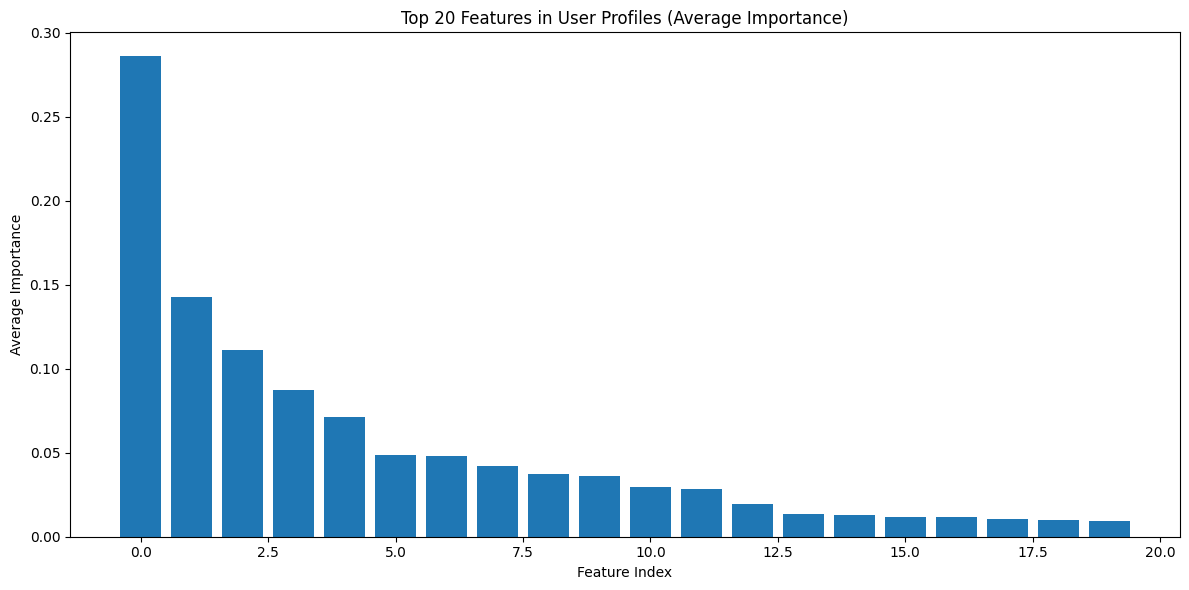

In [128]:
analyze_user_profiles(user_profiles, len(next(iter(enhanced_article_features.values()))))

In [129]:
sample_user_id = list(user_profiles.keys())[0]
recommendations = generate_recommendations(
    sample_user_id, 
    user_profiles, 
    enhanced_article_features, 
    behavior_polars_train.to_pandas(), 
    news_df
)


User U450328 has read 8 articles


In [130]:

evaluation_results = evaluate_content_based_model(
    user_profiles,
    enhanced_article_features,
    behavior_polars_dev
)


Generating predictions for evaluation...
Processing 51730 impressions for 1350 unique impression IDs
Generated 49000 predictions in 1.78 seconds


In [132]:
pd.DataFrame(evaluation_results, index=[0])

,auc,mrr,ndcg@5,ndcg@10
0,0.605651,0.312831,0.328904,0.377947
